In [1]:
!pip install datasets>=1.18.3
!pip install transformers==4.17.0
!pip install librosa
!pip install seaborn
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 36.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.18.0
    Uninstalling transformers-4.18.0:
      Successfully uninstalled transformers-4.18.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.0.4
    Uninstalling click-8.0.4:
      Successfully uninstalled click-8.0.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
spacy 3.2.4 requires click<8.1.0, but you have click 8.1.8 which is incompatible.
spacy 3.2.4 requires typing-extensions<4.0.0.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.

# Dataset

In [2]:
from datasets import load_dataset, load_metric, Audio, Dataset
from tqdm.auto import tqdm

import os
import numpy as np
import pandas as pd
import torchaudio

os.environ["WANDB_DISABLED"] = "true"

## Let's load dataset

In [3]:
timit_path = '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/'

In [4]:
data_path = '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/data/'

In [5]:
df_train = pd.read_csv(os.path.join(timit_path, 'train_data.csv'))
df_test = pd.read_csv(os.path.join(timit_path, 'test_data.csv'))
df = pd.concat([df_train, df_test])
df = df[df['is_converted_audio'] == False]

In [6]:
df

,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
1,2.0,TRAIN,DR4,MMDM0,SI1311.PHN,TRAIN/DR4/MMDM0/SI1311.PHN,TRAIN\\DR4\\MMDM0\\SI1311.PHN,False,False,False,True,False
2,3.0,TRAIN,DR4,MMDM0,SI1311.WRD,TRAIN/DR4/MMDM0/SI1311.WRD,TRAIN\\DR4\\MMDM0\\SI1311.WRD,False,False,True,False,False
3,4.0,TRAIN,DR4,MMDM0,SX321.PHN,TRAIN/DR4/MMDM0/SX321.PHN,TRAIN\\DR4\\MMDM0\\SX321.PHN,False,False,False,True,False
4,5.0,TRAIN,DR4,MMDM0,SX321.WRD,TRAIN/DR4/MMDM0/SX321.WRD,TRAIN\\DR4\\MMDM0\\SX321.WRD,False,False,True,False,False
5,6.0,TRAIN,DR4,MMDM0,SI681.TXT,TRAIN/DR4/MMDM0/SI681.TXT,TRAIN\\DR4\\MMDM0\\SI681.TXT,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
8394,8395.0,TEST,DR8,MPAM0,SX19.WAV,TEST/DR8/MPAM0/SX19.WAV,TEST\\DR8\\MPAM0\\SX19.WAV,False,True,False,False,False
8395,8396.0,TEST,DR8,MPAM0,SX109.TXT,TEST/DR8/MPAM0/SX109.TXT,TEST\\DR8\\MPAM0\\SX109.TXT,False,False,False,False,True
8397,8398.0,TEST,DR8,MPAM0,SX289.WRD,TEST/DR8/MPAM0/SX289.WRD,TEST\\DR8\\MPAM0\\SX289.WRD,False,False,True,False,False
8398,8399.0,TEST,DR8,MPAM0,SX109.WAV,TEST/DR8/MPAM0/SX109.WAV,TEST\\DR8\\MPAM0\\SX109.WAV,False,True,False,False,False


## Split Dataset

### Merge Entries
One entry in the dataframe represents one file. Audio, word, and phonetics are stored separately in different files. Then, we would need to combine them.

In [7]:
data = {}

for idx, row in tqdm(df.iterrows()):
    path = row['path_from_data_dir']
    entry_id = path.split('.')[0]

    if entry_id not in data:
        data[entry_id] = {}

    if row['is_audio'] is True:
        data[entry_id]['audio_file'] = os.path.join(data_path, path)
    elif row['is_word_file'] is True:
        data[entry_id]['word_file'] = os.path.join(data_path, path)
    elif row['is_phonetic_file'] is True:
        data[entry_id]['phonetic_file'] = os.path.join(data_path, path)

0it [00:00, ?it/s]

### Random Split 
We split the data randomly into 80/10/10.

In [8]:
import random

keys = [key for key in data.keys() if len(data[key]) == 3]
random.Random(101).shuffle(keys)

num_train = int(len(keys) * 0.8)
num_valid = int(len(keys) * 0.1)
num_test = len(keys) - num_train - num_valid

train_keys = keys[:num_train]
valid_keys = keys[num_train:num_train + num_valid]
test_keys = keys[-num_test:]

In [9]:
train = { key:data[key] for key in train_keys }
valid = { key:data[key] for key in valid_keys }
test  = { key:data[key] for key in test_keys }

### How many hours are in each set?
At least this helps us understand how big/small our dataset is.

In [10]:
import librosa

def get_durations(dict_data):
    total_durations = 0

    for entry in dict_data.values():
        audio_data, _ = librosa.load(entry['audio_file'], sr=16_000)
        duration = len(audio_data) / 16_000
        total_durations += duration

    return int(total_durations)

In [11]:
print(f"Duration of Train: {get_durations(train) // 60} mns")
print(f"Duration of Valid: {get_durations(valid) // 60} mns")
print(f"Duration of Test : {get_durations(test) // 60} mns")

Duration of Train: 137 mns
Duration of Valid: 17 mns
Duration of Test : 17 mns


### Save the Split into Files
This is for consistency. Different train/test set could yield different performance.
Hence, we just save them so that later we don't need to redo the split.

In [12]:
import json

with open("/kaggle/working/custom_train.json", "w") as f:
    json.dump(train, f)
with open("/kaggle/working/custom_valid.json", "w") as f:
    json.dump(valid, f)
with open("/kaggle/working/custom_test.json", "w") as f:
    json.dump(test, f)

# Preprocessing

## Process into HuggingFace Dataset Format

In [13]:
def convert_to_feature_dict(data_dict):
    # convert each feature into an array instead
    audio_files = []
    word_files = []
    phonetic_files = []
    for key, value in data_dict.items():
        audio_files.append(value['audio_file'])
        word_files.append(value['word_file'])
        phonetic_files.append(value['phonetic_file'])
    
    return {
        'audio_file': audio_files,
        'word_file': word_files,
        'phonetic_file': phonetic_files
    }

In [14]:
train = convert_to_feature_dict(train)
valid = convert_to_feature_dict(valid)
test  = convert_to_feature_dict(test)

In [15]:
train_dataset = Dataset.from_dict(train)
valid_dataset = Dataset.from_dict(valid)
test_dataset = Dataset.from_dict(test)

In [16]:
print(train_dataset)

Dataset({
    features: ['audio_file', 'word_file', 'phonetic_file'],
    num_rows: 2688
})


## Read files for phonetics

In [17]:
def read_text_file(filepath):
    with open(filepath) as f:
        tokens = [line.split()[-1] for line in f]
        return " ".join(tokens)
    
def prepare_text_data(item):
    item['text'] = read_text_file(item['word_file'])
    item['phonetic'] = read_text_file(item['phonetic_file'])
    return item

In [18]:
train_dataset = (train_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))
valid_dataset = (valid_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))
test_dataset  = (test_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))

  0%|          | 0/2688 [00:00<?, ?ex/s]

  0%|          | 0/336 [00:00<?, ?ex/s]

  0%|          | 0/336 [00:00<?, ?ex/s]

## Normalize the Phonetics

As we can see the result below, there are *61* phones. However, we don't need to use all of them. "tcl", for example, is just a pause where there is a "t". So, let's keep it up and simplify them a bit.

In [19]:
train_phonetics = [phone for x in train_dataset for phone in x['phonetic'].split()]
print("num of train phones:\t", len(set(train_phonetics)))

num of train phones:	 61


In [20]:
# TimitBet 61 phoneme mapping to 39 phonemes
# by Lee, K.-F., & Hon, H.-W. (1989). Speaker-independent phone recognition using hidden Markov models. IEEE Transactions on Acoustics, Speech, and Signal Processing, 37(11), 1641–1648. doi:10.1109/29.46546 
phon61_map39 = {
    'iy':'iy',  'ih':'ih',   'eh':'eh',  'ae':'ae',    'ix':'ih',  'ax':'ah',   'ah':'ah',  'uw':'uw',
    'ux':'uw',  'uh':'uh',   'ao':'aa',  'aa':'aa',    'ey':'ey',  'ay':'ay',   'oy':'oy',  'aw':'aw',
    'ow':'ow',  'l':'l',     'el':'l',  'r':'r',      'y':'y',    'w':'w',     'er':'er',  'axr':'er',
    'm':'m',    'em':'m',     'n':'n',    'nx':'n',     'en':'n',  'ng':'ng',   'eng':'ng', 'ch':'ch',
    'jh':'jh',  'dh':'dh',   'b':'b',    'd':'d',      'dx':'dx',  'g':'g',     'p':'p',    't':'t',
    'k':'k',    'z':'z',     'zh':'sh',  'v':'v',      'f':'f',    'th':'th',   's':'s',    'sh':'sh',
    'hh':'hh',  'hv':'hh',   'pcl':'h#', 'tcl':'h#', 'kcl':'h#', 'qcl':'h#','bcl':'h#','dcl':'h#',
    'gcl':'h#','h#':'h#',  '#h':'h#',  'pau':'h#', 'epi': 'h#','nx':'n',   'ax-h':'ah','q':'h#' 
}

def convert_phon61_to_phon39(sentence):
    tokens = [phon61_map39[x] for x in sentence.split()]
    return " ".join(tokens)

def normalize_phones(item):
    item['phonetic'] = convert_phon61_to_phon39(item['phonetic'])
    return item

In [21]:
train_dataset = train_dataset.map(normalize_phones)
valid_dataset = valid_dataset.map(normalize_phones)
test_dataset = test_dataset.map(normalize_phones)

  0%|          | 0/2688 [00:00<?, ?ex/s]

  0%|          | 0/336 [00:00<?, ?ex/s]

  0%|          | 0/336 [00:00<?, ?ex/s]

In [22]:
train_phonetics = [phone for x in train_dataset for phone in x['phonetic'].split()]
valid_phonetics = [phone for x in valid_dataset for phone in x['phonetic'].split()]
test_phonetics = [phone for x in test_dataset for phone in x['phonetic'].split()]

print("num of train phones:\t", len(set(train_phonetics)))
print("num of valid phones:\t", len(set(valid_phonetics)))
print("num of test phones:\t", len(set(test_phonetics)))

num of train phones:	 39
num of valid phones:	 39
num of test phones:	 39


## Phonetic Distribution
Let's check the distribution of each phone across all three test set. Note that we don't do simple counting. Instead, for each phoneme, we show the ratio of that phoneme relative to that specific set. On test set, obviously, the count of each phoneme is less than the train, but the ratio should be similar to the training set.

In [23]:
phone_vocabs = set(train_phonetics)
phone_vocabs.remove('h#')
phone_vocabs = sorted(phone_vocabs)

def count_frequency(phonetics):
    phone_counts = {phone: 0 for phone in phone_vocabs}
    for phone in phonetics:
        if phone in phone_vocabs:
            phone_counts[phone] += 1
    # eliminate h# for visualization purposes
    return [phone_counts[phone] for phone in phone_vocabs] 

In [24]:
train_phone_counts = count_frequency(train_phonetics)
valid_phone_counts = count_frequency(valid_phonetics)
test_phone_counts  = count_frequency(test_phonetics)

In [25]:
train_phone_ratio = [count / sum(train_phone_counts) for count in train_phone_counts]
valid_phone_ratio = [count / sum(valid_phone_counts) for count in valid_phone_counts]
test_phone_ratio  = [count / sum(test_phone_counts) for count in test_phone_counts]

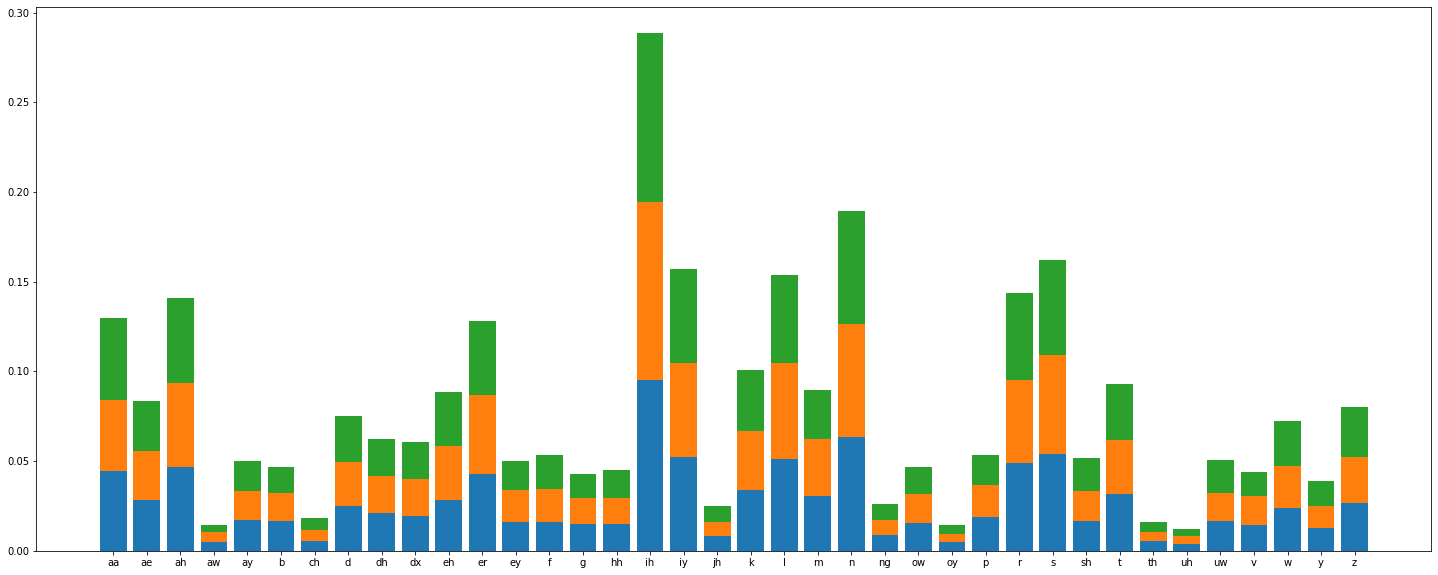

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))

plt.bar(phone_vocabs, train_phone_ratio)
plt.bar(phone_vocabs, valid_phone_ratio, bottom=train_phone_ratio)
plt.bar(phone_vocabs, test_phone_ratio, bottom=[(x+y) for x,y in zip(train_phone_ratio, valid_phone_ratio)])

plt.show()

## Load Audio File

In [27]:
train_dataset = (train_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))
valid_dataset = (valid_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))
test_dataset = (test_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))

In [28]:
train_dataset[0]

{'audio': {'path': '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/data/TEST/DR7/FISB0/SA1.WAV',
  'array': array([-6.1035156e-05,  6.1035156e-05,  1.2207031e-04, ...,
          9.1552734e-05,  3.6621094e-04, -3.0517578e-04], dtype=float32),
  'sampling_rate': 16000},
 'text': 'she had your dark suit in greasy wash water all year',
 'phonetic': 'h# sh iy hh ae h# d y er h# d aa r h# k s uw h# ih n h# g r iy z iy w aa sh h# w aa dx er h# aa l y ih er h#'}

In [29]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(train_dataset)-1)

print("Text:", train_dataset[rand_int]["text"])
print("Phonetics:", train_dataset[rand_int]["phonetic"])
print("Input array shape:", train_dataset[rand_int]["audio"]["array"].shape)
print("Sampling rate:", train_dataset[rand_int]["audio"]["sampling_rate"])
ipd.Audio(data=train_dataset[rand_int]["audio"]["array"], autoplay=False, rate=16000)

Text: chief interest in radiosterilization resides in the military services
Phonetics: h# ch iy f ih n h# t er s h# t ih n r ey dx iy uh s h# t eh er l ah z ey sh ih n r ih z ay h# z ih n dh ih m ih l ih h# t eh r ih s er v er s ih z h#
Input array shape: (69325,)
Sampling rate: 16000


## Build Character Set

In [30]:
vocab_train = list(set(train_phonetics)) + [' ']
vocab_valid = list(set(valid_phonetics)) + [' ']
vocab_test  = list(set(test_phonetics)) + [' ']

In [31]:
vocab_list = list(set(vocab_train + vocab_valid + vocab_test))
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}

print(vocab_dict)

{' ': 0, 'aa': 1, 'ae': 2, 'ah': 3, 'aw': 4, 'ay': 5, 'b': 6, 'ch': 7, 'd': 8, 'dh': 9, 'dx': 10, 'eh': 11, 'er': 12, 'ey': 13, 'f': 14, 'g': 15, 'h#': 16, 'hh': 17, 'ih': 18, 'iy': 19, 'jh': 20, 'k': 21, 'l': 22, 'm': 23, 'n': 24, 'ng': 25, 'ow': 26, 'oy': 27, 'p': 28, 'r': 29, 's': 30, 'sh': 31, 't': 32, 'th': 33, 'uh': 34, 'uw': 35, 'v': 36, 'w': 37, 'y': 38, 'z': 39}


In [32]:
# make the space more intuitive to understand
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

42

In [33]:
# save vocab.json
import json
with open('/kaggle/working/vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

## IPA Symbol
We won't use these symbols in this notebook. This is just for reference, in case you need them.

In [34]:
symbols = {"a": "ə", "ey": "eɪ", "aa": "ɑ", "ae": "æ", "ah": "ə", "ao": "ɔ",
           "aw": "aʊ", "ay": "aɪ", "ch": "ʧ", "dh": "ð", "eh": "ɛ", "er": "ər",
           "hh": "h", "ih": "ɪ", "jh": "ʤ", "ng": "ŋ",  "ow": "oʊ", "oy": "ɔɪ",
           "sh": "ʃ", "th": "θ", "uh": "ʊ", "uw": "u", "zh": "ʒ", "iy": "i", "y": "j"}

# Modeling

## Input Processor

In [35]:
from transformers import Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2Processor
from tokenizers.processors import TemplateProcessing

In [36]:
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("/kaggle/working/", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|", )  # './' load vocab.json in the current directory
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)  
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [37]:
# This does not prepare the input for the Transformer model.
# This will resample the data and convert the sentence into indices
# Batch here is just for one entry (row)
def prepare_dataset(batch):
    audio = batch["audio"]
    
    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["phonetic"]).input_ids
    return batch

In [38]:
# train_dataset = train_dataset.map(prepare_dataset, remove_columns=train_dataset.column_names)
# valid_dataset = valid_dataset.map(prepare_dataset, remove_columns=valid_dataset.column_names)
# test_dataset = test_dataset.map(prepare_dataset, remove_columns=test_dataset.column_names)
train_dataset = train_dataset.map(prepare_dataset)
valid_dataset = valid_dataset.map(prepare_dataset)
test_dataset = test_dataset.map(prepare_dataset)

  0%|          | 0/2688 [00:00<?, ?ex/s]

  0%|          | 0/336 [00:00<?, ?ex/s]

  0%|          | 0/336 [00:00<?, ?ex/s]

In [39]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch

## Evaluation Metrics

We use WER (Word Error Rate) and CER (Character Error Rate) to measure the performance of our model. After the training, we realize that WER may not be the right fit. CER fits better.

Note that CER here has some errors in our use case because each ARPAbet token is represented by one to three characters. For example, a label token is "ch" and another is "ae", that's two character error right there.

After the training, we will re-evaluate on test-set one more time, which we will evaluate at token level.

In [40]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = tokenizer.pad_token_id

    pred_str = tokenizer.batch_decode(pred_ids)
    label_str = tokenizer.batch_decode(pred.label_ids, group_tokens=False)
    
    #wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    
    print("Predicted sample", pred_str[0])
    print("GT sample", label_str[0])

    return {
        #"wer": wer,
        "cer": cer
    }

In [41]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)
# wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [42]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-xls-r-300m", 
    attention_dropout=0.1,
    layerdrop=0.0,
    feat_proj_dropout=0.0,
#     mask_time_prob=0.75, 
#     mask_time_length=10,
#     mask_feature_prob=0.25,
#     mask_feature_length=64,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-xls-r-300m were not used when initializing Wav2Vec2ForCTC: ['quantizer.codevectors', 'quantizer.weight_proj.bias', 'project_q.bias', 'project_hid.weight', 'quantizer.weight_proj.weight', 'project_hid.bias', 'project_q.weight']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-xls-r-300m and are newly initialized: ['lm_head.weight', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to use it 

In [43]:
model.freeze_feature_encoder()

## Training

In [44]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='/kaggle/working/',
    group_by_length=True,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    evaluation_strategy="steps",
    gradient_checkpointing=True,
    fp16=True,
    max_steps=2000,
    save_steps=100,  #100,
    eval_steps=100,
    logging_steps=100,
    learning_rate=1e-4,
    warmup_steps=20,
    save_total_limit=3,
    load_best_model_at_end=True
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [45]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=processor.feature_extractor
)

max_steps is given, it will override any value given in num_train_epochs
Using amp half precision backend


In [46]:
os.environ["WANDB_DISABLED"] = "true"
trainer.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2688
  Num Epochs = 24
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2000
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors we

Step,Training Loss,Validation Loss,Cer
100,5.023300,3.283651,1.000000
200,3.085800,2.644819,0.746826
300,1.979700,0.898844,0.163344
400,0.949100,0.547953,0.120537
500,0.701600,0.453629,0.100142
600,0.598100,0.405588,0.095971
700,0.536900,0.381533,0.089876
800,0.489900,0.380843,0.090197
900,0.448100,0.355521,0.086576
1000,0.417700,0.354042,0.086988


The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size = 16


Predicted sample 
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-100
Configuration saved in /kaggle/working/checkpoint-100/config.json
Model weights saved in /kaggle/working/checkpoint-100/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-100/preprocessor_config.json
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size = 16


Predicted sample h#h#kth#th#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-200
Configuration saved in /kaggle/working/checkpoint-200/config.json
Model weights saved in /kaggle/working/checkpoint-200/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-200/preprocessor_config.json
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size = 16


Predicted sample h#wihh#d uwuwlaaayh#k sahvaylihnh#t sh#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-300
Configuration saved in /kaggle/working/checkpoint-300/config.json
Model weights saved in /kaggle/working/checkpoint-300/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-300/preprocessor_config.json
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size = 16


Predicted sample h#wihh#d yuwahloyaeh#k sahvaylahnh#t sh#h#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-400
Configuration saved in /kaggle/working/checkpoint-400/config.json
Model weights saved in /kaggle/working/checkpoint-400/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-400/preprocessor_config.json
Deleting older checkpoint [/kaggle/working/checkpoint-100] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size = 16

Predicted sample h#wuhh#d yuwahlawh#aeh#k sahvvaylahnh#t sh#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-500
Configuration saved in /kaggle/working/checkpoint-500/config.json
Model weights saved in /kaggle/working/checkpoint-500/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-500/preprocessor_config.json
Deleting older checkpoint [/kaggle/working/checkpoint-200] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size = 16

Predicted sample h#wuhh#d yuwahlawh#aeh#k sahvaylahnh#t sh#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-600
Configuration saved in /kaggle/working/checkpoint-600/config.json
Model weights saved in /kaggle/working/checkpoint-600/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-600/preprocessor_config.json
Deleting older checkpoint [/kaggle/working/checkpoint-300] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size = 16

Predicted sample h#wihh#d yuwahlawh#aeh#k sahvaylahnh#t sh#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-700
Configuration saved in /kaggle/working/checkpoint-700/config.json
Model weights saved in /kaggle/working/checkpoint-700/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-700/preprocessor_config.json
Deleting older checkpoint [/kaggle/working/checkpoint-400] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size = 16

Predicted sample h#wuhh#d yuwahlawh#aeh#k sahvaylahnh#t sh#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-800
Configuration saved in /kaggle/working/checkpoint-800/config.json
Model weights saved in /kaggle/working/checkpoint-800/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-800/preprocessor_config.json
Deleting older checkpoint [/kaggle/working/checkpoint-500] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size = 16

Predicted sample h#wuhh#d yuwahlawh#aeh#k sahvaylahnh#t sh#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-900
Configuration saved in /kaggle/working/checkpoint-900/config.json
Model weights saved in /kaggle/working/checkpoint-900/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-900/preprocessor_config.json
Deleting older checkpoint [/kaggle/working/checkpoint-600] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size = 16

Predicted sample h#wuhh#d yuwahlawh#aeh#k sahvaylahnh#t sh#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-1000
Configuration saved in /kaggle/working/checkpoint-1000/config.json
Model weights saved in /kaggle/working/checkpoint-1000/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-1000/preprocessor_config.json
Deleting older checkpoint [/kaggle/working/checkpoint-700] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size 

Predicted sample h#wuhh#d yuwahlawaeh#k sahvaylahnh#t sh#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-1100
Configuration saved in /kaggle/working/checkpoint-1100/config.json
Model weights saved in /kaggle/working/checkpoint-1100/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-1100/preprocessor_config.json
Deleting older checkpoint [/kaggle/working/checkpoint-800] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size 

Predicted sample h#wuhh#d yuwahlawaeh#k sahvaylahnh#t sh#h#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-1200
Configuration saved in /kaggle/working/checkpoint-1200/config.json
Model weights saved in /kaggle/working/checkpoint-1200/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-1200/preprocessor_config.json
Deleting older checkpoint [/kaggle/working/checkpoint-900] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size 

Predicted sample h#wuhh#d yuwahlawh#aeh#k sahvaylahnh#t sh#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-1300
Configuration saved in /kaggle/working/checkpoint-1300/config.json
Model weights saved in /kaggle/working/checkpoint-1300/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-1300/preprocessor_config.json
Deleting older checkpoint [/kaggle/working/checkpoint-1000] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size

Predicted sample h#wuhh#d yuwahlawaeh#k sahvaylahnh#t sh#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-1400
Configuration saved in /kaggle/working/checkpoint-1400/config.json
Model weights saved in /kaggle/working/checkpoint-1400/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-1400/preprocessor_config.json
Deleting older checkpoint [/kaggle/working/checkpoint-1100] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size

Predicted sample h#wuhh#d yuwahlawaeh#k sahvaylahnh#t sh#h#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-1500
Configuration saved in /kaggle/working/checkpoint-1500/config.json
Model weights saved in /kaggle/working/checkpoint-1500/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-1500/preprocessor_config.json
Deleting older checkpoint [/kaggle/working/checkpoint-1200] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size

Predicted sample h#wuhh#d yuwahlawaeh#k sahvaylahnh#t sh#h#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-1600
Configuration saved in /kaggle/working/checkpoint-1600/config.json
Model weights saved in /kaggle/working/checkpoint-1600/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-1600/preprocessor_config.json
Deleting older checkpoint [/kaggle/working/checkpoint-1300] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size

Predicted sample h#wuhh#d yuwahlawaeh#k sahvaylahnh#t sh#h#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-1700
Configuration saved in /kaggle/working/checkpoint-1700/config.json
Model weights saved in /kaggle/working/checkpoint-1700/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-1700/preprocessor_config.json
Deleting older checkpoint [/kaggle/working/checkpoint-1500] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size

Predicted sample h#wuhh#d yuwahlawaeh#k sahvaylahnh#t sh#h#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-1800
Configuration saved in /kaggle/working/checkpoint-1800/config.json
Model weights saved in /kaggle/working/checkpoint-1800/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-1800/preprocessor_config.json
Deleting older checkpoint [/kaggle/working/checkpoint-1600] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size

Predicted sample h#wuhh#d yuwahlawaeh#k sahvaylahnh#t sh#h#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-1900
Configuration saved in /kaggle/working/checkpoint-1900/config.json
Model weights saved in /kaggle/working/checkpoint-1900/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-1900/preprocessor_config.json
Deleting older checkpoint [/kaggle/working/checkpoint-1700] due to args.save_total_limit
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size

Predicted sample h#wuhh#d yuwahlawaeh#k sahvaylahnh#t sh#h#
GT sample h#wuhh#d yuwahlawaeh#k sahvaylihnh#sh#


Saving model checkpoint to /kaggle/working/checkpoint-2000
Configuration saved in /kaggle/working/checkpoint-2000/config.json
Model weights saved in /kaggle/working/checkpoint-2000/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-2000/preprocessor_config.json
Deleting older checkpoint [/kaggle/working/checkpoint-1800] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /kaggle/working/checkpoint-1400 (score: 0.32281526923179626).


TrainOutput(global_step=2000, training_loss=0.8625827150344849, metrics={'train_runtime': 16907.1921, 'train_samples_per_second': 3.785, 'train_steps_per_second': 0.118, 'total_flos': 6.263664947469473e+18, 'train_loss': 0.8625827150344849, 'epoch': 23.81})

## Evaluate on Test Set

In [47]:
trainer.evaluate(test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Predicted sample h#tehn yiherzihh#gowdheyh#b luwahh#p sahnah vaarh#dihh#chihsh#
GT sample h#tehn yihr zihh#gowdheyh#b luwahh#p sahmahvaarh#dihh#chihsh#


{'eval_loss': 0.3380519449710846,
 'eval_cer': 0.08458352508053382,
 'eval_runtime': 13.1671,
 'eval_samples_per_second': 25.518,
 'eval_steps_per_second': 1.595,
 'epoch': 23.81}

In [48]:
trainer.evaluate(train_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: phonetic, text, input_length, audio. If phonetic, text, input_length, audio are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2688
  Batch size = 16


Predicted sample h#shiyhhaeh#d yerh#daarh#k suwh#ihnh#g riyziywaashh#waadxerh#aal yiherh#
GT sample h#shiyhhaeh#d yerh#daarh#k suwh#ihnh#g riyziywaashh#waadxerh#aal yiherh#


{'eval_loss': 0.12003766745328903,
 'eval_cer': 0.03579557210842127,
 'eval_runtime': 104.1209,
 'eval_samples_per_second': 25.816,
 'eval_steps_per_second': 1.614,
 'epoch': 23.81}

## Save Model

In [49]:
# save locally
# trainer.save_model()
trainer.save_model("/kaggle/working/phoneme_recognition")


Saving model checkpoint to /kaggle/working/phoneme_recognition
Configuration saved in /kaggle/working/phoneme_recognition/config.json
Model weights saved in /kaggle/working/phoneme_recognition/pytorch_model.bin
Feature extractor saved in /kaggle/working/phoneme_recognition/preprocessor_config.json


In [50]:
!zip -r /kaggle/working/phoneme_recognition.zip /kaggle/working/phoneme_recognition


  adding: kaggle/working/phoneme_recognition/ (stored 0%)
  adding: kaggle/working/phoneme_recognition/config.json (deflated 64%)
  adding: kaggle/working/phoneme_recognition/pytorch_model.bin (deflated 8%)
  adding: kaggle/working/phoneme_recognition/preprocessor_config.json (deflated 35%)
  adding: kaggle/working/phoneme_recognition/training_args.bin (deflated 48%)


In [51]:
# trainer.push_to_hub(repo_name="vitouphy/wav2vec2-xls-r-300m-phoneme")

In [52]:
# tokenizer.push_to_hub('vitouphy/xls-r-300m-km')
# model.push_to_hub(repo_path_or_name='vitouphy/wav2vec2-xls-r-300m-phoneme')

# Error Analysis

## Closer Look at Test Set
Let's run the prediction on the test one more time.

In [53]:
import Levenshtein
from typing import Tuple

In [54]:
PAD_ID = tokenizer.encode("[PAD]")[0]
EMPTY_ID = tokenizer.encode(" ")[0]

def collapse_tokens(tokens: List[Union[str, int]]) -> List[Union[str, int]]:
    prev_token = None
    out = []
    for token in tokens:
        if token != prev_token and prev_token is not None:
            out.append(prev_token)
        prev_token = token
    return out

def clean_token_ids(token_ids: List[int]) -> List[int]:
    """
    Remove [PAD] and collapse duplicated token_ids
    """
    token_ids = [x for x in token_ids if x not in [PAD_ID, EMPTY_ID]]
    token_ids = collapse_tokens(token_ids)
    return token_ids

def decode_operations(predicted_chr: str, label_chr: str, editops: List[Tuple[str, int, int]]) -> List[Tuple[str, str, str]]:
    ops = []
    for editop in editops:
        op, pred_idx, label_idx = editop
        
        if op == "insert":
            label_token = tokenizer.decode(ord(label_chr[label_idx]), group_tokens=False)
            ops.append((op, label_token, label_token))
        elif op == "delete":
            pred_token = tokenizer.decode(ord(predicted_chr[pred_idx]), group_tokens=False)
            ops.append((op, pred_token, pred_token))
        else:
            label_token = tokenizer.decode(ord(label_chr[label_idx]), group_tokens=False)
            pred_token = tokenizer.decode(ord(predicted_chr[pred_idx]), group_tokens=False)
            ops.append((op, pred_token, label_token))
            
    return ops

In [55]:
result = []
for x in tqdm(test_dataset):
    example_id = "/".join(x['audio']['path'].split('/')[5:])
    input_values = torch.Tensor(x['input_values']).unsqueeze(0).to('cuda')
    label_ids = torch.Tensor(x['labels']).unsqueeze(0).to('cuda')
    
    with torch.no_grad():
        logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        
        # Convert ID to Char because Levenstein library operates on char level
        predicted_ids = clean_token_ids(predicted_ids[0].tolist())
        predicted_str = tokenizer.decode(predicted_ids, group_tokens=False)
        predicted_chr = "".join([chr(x) for x in predicted_ids])
        
        label_ids = clean_token_ids(label_ids[0].int().tolist())
        label_str = tokenizer.decode(label_ids, group_tokens=False)
        label_chr = "".join([chr(x) for x in label_ids])
        
        # Compute CER (character-error rate). Each character is IPA character
        cer_score = cer_metric.compute(predictions=[predicted_chr], references=[label_chr])

        # Observe the operations like insertion, deletion and substitution
        editops = Levenshtein.editops(predicted_chr, label_chr)
        editops = decode_operations(predicted_chr, label_chr, editops)
        
        result.append((example_id, predicted_str, label_str, editops, cer_score))

  0%|          | 0/336 [00:00<?, ?it/s]

In [56]:
# Recalculate CER store for Test Set
total_cer = 0
for entry in result:
    total_cer += entry[-1]
print(f"Avg CER score: {total_cer / len(result)}")

Avg CER score: 0.09959625838663687


## Visualization Insertion/Deletion

In [57]:
result[0]

('TRAIN/DR3/MBEF0/SI1911.WAV',
 'h#tehnyiherzihh#gowdheyh#bluwahh#psahnahvaarh#dihh#chihs',
 'h#tehnyihrzihh#gowdheyh#bluwahh#psahmahvaarh#dihh#chihs',
 [('replace', 'er', 'r'), ('replace', 'n', 'm')],
 0.06451612903225806)

In [58]:
insertions = []
deletions = []
replaces = []

for entry in result:
    editops = entry[3]
    for op, pred_token, label_token in editops:
        if op == "insert":
            insertions.append(label_token)
        elif op == "delete":
            deletions.append(pred_token)
        else:
            replaces.append((pred_token, label_token))

In [59]:
insert_freqs = {x: 0 for x in set(insertions)}
for insert_token in insertions:
    insert_freqs[insert_token] += 1
    
delete_freqs = {x: 0 for x in set(deletions)}
for delete_token in deletions:
    delete_freqs[delete_token] += 1

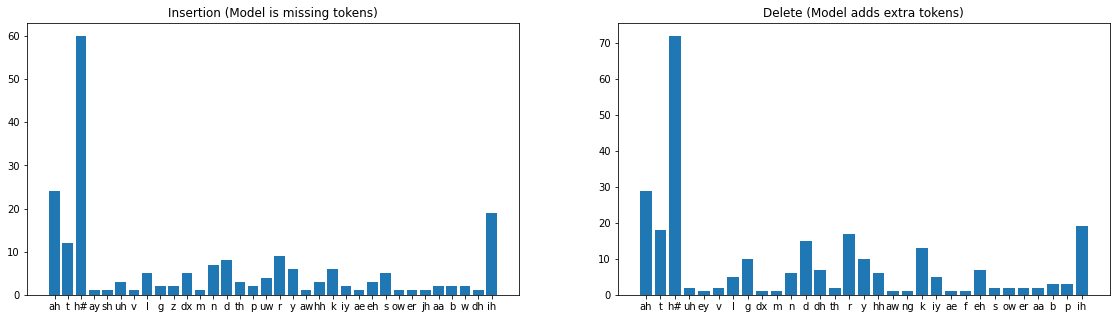

In [60]:
plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.bar(insert_freqs.keys(), insert_freqs.values())
plt.title('Insertion (Model is missing tokens)')

plt.subplot(1,3,2)
plt.bar(delete_freqs.keys(), delete_freqs.values())
plt.title('Delete (Model adds extra tokens)')

plt.show()

The two figure aboves shows that:
- Model are confused for tokens "ah", "t", "ih", "h#". The model either added those tokens when it's not needed or didn't add them where it's needed.
- Model tends to add extra on "r", "d", "k" "g"

## Visualize With Substitution

In [61]:
replace_freqs = {}
for replace in replaces:
    if replace not in replace_freqs:
        replace_freqs[replace] = 0
    replace_freqs[replace] += 1

In [62]:
sorted_replace_freqs = sorted(replace_freqs.items(), key=lambda x: x[-1], reverse=True)
top_replace_freqs = list(filter(lambda x: x[-1] >= 5, sorted_replace_freqs))

In [63]:
top_replace_freqs

[(('ih', 'ah'), 68),
 (('ah', 'ih'), 58),
 (('iy', 'ih'), 45),
 (('ih', 'iy'), 28),
 (('ih', 'eh'), 19),
 (('eh', 'ih'), 17),
 (('s', 'z'), 16),
 (('r', 'er'), 14),
 (('aa', 'ah'), 13),
 (('z', 's'), 13),
 (('ae', 'eh'), 11),
 (('er', 'r'), 10),
 (('er', 'ah'), 10),
 (('aa', 'ay'), 9),
 (('er', 'ih'), 9),
 (('ah', 'eh'), 9),
 (('ng', 'n'), 7),
 (('ey', 'eh'), 6),
 (('ey', 'ih'), 6),
 (('dx', 'h#'), 6),
 (('d', 't'), 6),
 (('ih', 'ey'), 6),
 (('eh', 'ae'), 6),
 (('n', 'ng'), 6),
 (('t', 'd'), 5),
 (('ih', 'uw'), 5),
 (('dh', 'd'), 5),
 (('ay', 'aa'), 5),
 (('dx', 'd'), 5)]

In [64]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [65]:
src = set([src_token for (src_token, dst_token), freq in top_replace_freqs])
dst = set([dst_token for (src_token, dst_token), freq in top_replace_freqs])

src_indices = {x: i for i, x in enumerate(sorted(src))}
dst_indices = {x: i for i, x in enumerate(sorted(dst))}

In [66]:
matrix = [[0]*len(dst_indices) for _ in range(len(src_indices))]

for (src_token, dst_token), freq in top_replace_freqs:
    src_idx = src_indices[src_token]
    dst_idx = dst_indices[dst_token]
    matrix[src_idx][dst_idx] = freq

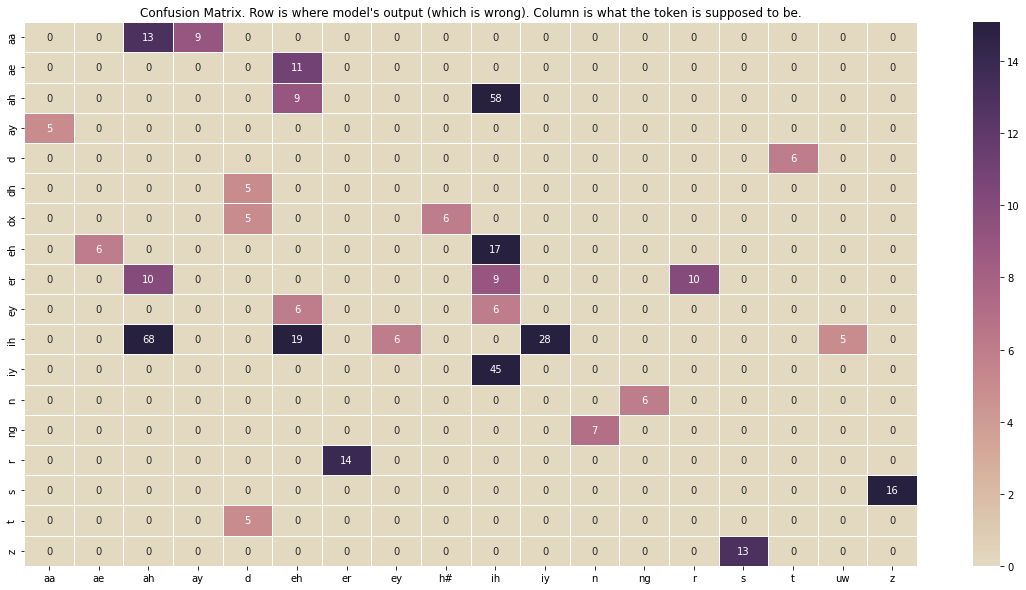

In [67]:
plt.figure(figsize=(20,10))
ax = sns.heatmap(matrix, linewidth=0.5, xticklabels=sorted(dst), yticklabels=sorted(src), cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True), annot=True, robust=True)
plt.title("Confusion Matrix. Row is where model's output (which is wrong). Column is what the token is supposed to be.")
plt.show()

The figure above illustrates the confusion matrix (partial). Here we can understand better how the model focuses between tokens.
- Model tends to confuse between 
  - "ih" <-> "ah"
  - "ih" <-> "eh"
  - "ih" <-> "iy"
- Model tends to output:
  - "aa" instead of "ah"
  - "ae" instead of "eh"
  - "er" instead of "ah"
  - "r" instead of "er"
